In [1]:
# Auto reload of modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Import
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, pinvh

from rates.auxillary import cat2one_hot
from rates.config import SAVE_DIR
from rates.datasets import noise_augmentations, circles, mixture
from rates.architectures import exp_kernel

# Config
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')

noise_level = 0
# circles = mixture
# noise_level = .3


In [3]:
n_train = 200
d = 4
n_test = 500
m = 2

sigma = 1
lambd = 1e-3

nb_trials = 10
nb_trials_distill = 5
mul_factor = 1
nb_distill = int(n_train / mul_factor)

alphas = [.5, 1e-3, 1e-6]
errors = np.zeros((len(alphas), nb_trials, nb_trials_distill, nb_distill))
x_test, y_test = circles(n_test, d=d, noise_level=noise_level, labels=True, test=True)
one_hot = cat2one_hot(y_test.astype(int) - 1)

for i in range(nb_trials):
    x_0, y_0 = circles(n_train, d=d, noise_level=noise_level, labels=True, test=False)
    x, y = noise_augmentations(x_0, y_0, m=m, eps=.1)
    Y_full = cat2one_hot(y)

    G_ssl = np.kron(np.eye(n_train), np.ones((m, m)))

    K = exp_kernel(x, x, sigma=sigma)
    K_test = exp_kernel(x_test, x, sigma=sigma)
    K_inv = pinvh(K, atol=0)
    tmp_x = K @ K_inv
    tmp_x_test = K_test @ K_inv

    for j in range(nb_trials_distill):

        Y = np.zeros(Y_full.shape)
        ind = list(np.random.permutation(np.arange(n_train)))

        for k in range(nb_distill):

            G_sup = Y @ Y.T

            for s, alpha in enumerate(alphas):
                G = (1-alpha) * G_ssl + alpha * G_sup

                T = G - lambd * K_inv
                w, v = eigh(T, subset_by_index=[len(T) - 5, len(T) - 1])

                phi = tmp_x_test @ v
                w = np.linalg.solve(phi.T @ phi, phi.T @ one_hot)
                pred = np.argmax(phi @ w, axis=1)
                errors[s, i, j, k] = (pred + 1 != y_test).mean()

            for t in range(mul_factor):
                ind_t = ind.pop()
                Y[m*ind_t] = Y_full[m*ind_t]

    print(i, end=",")

0,1,2,3,4,5,6,7,8,9,

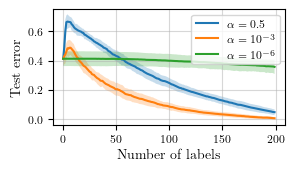

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
tmp_x = mul_factor * np.arange(nb_distill)

err = errors[0]
ax.plot(tmp_x, err.mean(axis=(0,1)), label=r"$\alpha=0.5$")
ax.fill_between(tmp_x, err.mean(axis=(0,1)) - err.std(axis=(0,1)), err.mean(axis=(0,1)) + err.std(axis=(0,1)), alpha=.25)

err = errors[1]
ax.plot(tmp_x, err.mean(axis=(0,1)), label=r"$\alpha=10^{-3}$")
ax.fill_between(tmp_x, err.mean(axis=(0,1)) - err.std(axis=(0,1)), err.mean(axis=(0,1)) + err.std(axis=(0,1)), alpha=.25)

err = errors[2]
ax.plot(tmp_x, err.mean(axis=(0,1)), label=r"$\alpha=10^{-6}$")
ax.fill_between(tmp_x, err.mean(axis=(0,1)) - err.std(axis=(0,1)), err.mean(axis=(0,1)) + err.std(axis=(0,1)), alpha=.25)

ax.set_xlabel("Number of labels")
ax.set_ylabel("Test error")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8)
ax.legend(fontsize=8, loc="upper right")
ax.grid(alpha=.5)
fig.savefig(SAVE_DIR / "interpolation.pdf", bbox_inches='tight', pad_inches=0)

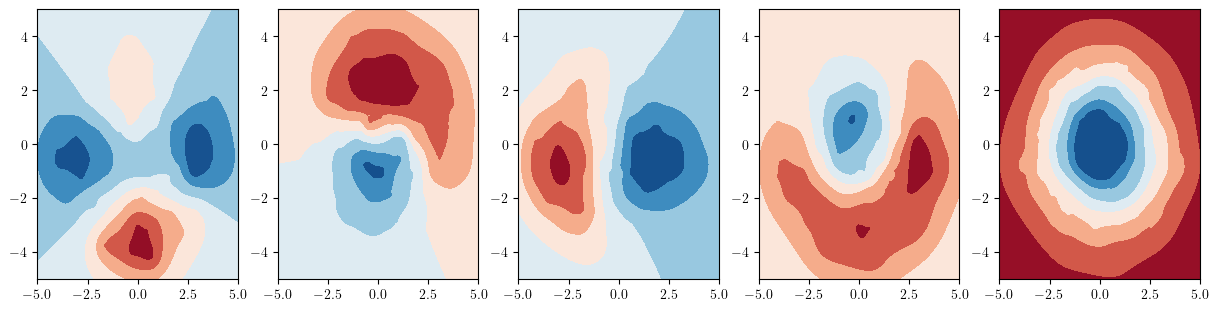

In [5]:
n_display_root = 100
tmp = np.linspace(-(d+1), (d+1), n_display_root)
X, Y = np.meshgrid(tmp, tmp)
x_display = np.vstack((X.flatten(), Y.flatten())).T
K_display = exp_kernel(x_display, x, sigma=sigma)
phi_display = K_display @ (K_inv @ v)

fig, axes = plt.subplots(1, 5, figsize=(15, 3.5))
for j in range(phi_display.shape[1]):
    axes[j].contourf(X, Y, phi_display[:, j].reshape(*X.shape), cmap='RdBu')